In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.ndimage

import sys

sys.path.append('../')
from carpet_reconstruction import find_smoothest_max, neighbors, VEM2rp, fit_coeffs, get_xy_fits, get_xy, get_rho, NKG, NKG_Vik

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import peak_local_max

from scipy.optimize import curve_fit
from scipy.special import gamma

In [2]:
#matplotlib.use('pdf')
plt.rcParams['figure.dpi'] = 300
#plt.style.use('fivethirtyeight')

In [3]:
all_data = pd.read_csv('../Data/Data_2023-2024_410_CarpetMeas.csv', sep=';', header = None)

In [4]:
carpet_signal_data = all_data.iloc[:, 20:420]
carpet_angle_data = all_data.iloc[:, 10:12]
carpet_Ne_data =  all_data.iloc[:, 16]
carpet_Nmu_data = all_data.iloc[:, 7] + all_data.iloc[:, 19]

In [5]:
carpet_signals = carpet_signal_data.to_numpy()
carpet_angles = carpet_angle_data.to_numpy()
carpet_Nes = carpet_Ne_data.to_numpy()
carpet_Nmu = carpet_Nmu_data.to_numpy()

# Upscale

In [ ]:
pdf = PdfPages("100_Real_Showers_reconsctruction_total_upscale.pdf")

upscale_factors = np.array([1, 2, 3, 5, 10, 50])

for i in range(100):

    sig = carpet_signals[i].reshape((20, 20))

    nRows = 2
    nColumns = 3

    fig, axs = plt.subplots(nRows, nColumns)

    for upscale_number, upscale_factor in enumerate(upscale_factors):

        k = (upscale_number) // nColumns
        j = upscale_number % nColumns
        
        upsc_sig = np.round(scipy.ndimage.zoom(sig, upscale_factor, order=3), 3)
    
        #peak_region = upsc_sig[xy[0]*upscale_factor:(xy[0]+1)*upscale_factor, xy[1]*upscale_factor:(xy[1]+1)*upscale_factor]
    
        axs[k, j].imshow(upsc_sig, cmap='turbo')
        axs[k, j].grid(False)
        
        axs[k, j].set_xticks(ticks=[])
        axs[k, j].set_yticks(ticks=[])
        
        coordinates_new = peak_local_max(upsc_sig, exclude_border=False, threshold_rel=0.1)
        xy_new = find_smoothest_max(upsc_sig, coordinates_new)
        
        #axs[1].axvline(x=xy[1]*upscale_factor + xy_new[1], linewidth=1, color='r')
        #axs[1].axhline(y=xy[0]*upscale_factor + xy_new[0], linewidth=1, color='r')
    
        axs[k, j].axvline(x = xy_new[1], linewidth=2, color='r')
        axs[k, j].axhline(y = xy_new[0], linewidth=2, color='r')

        if (k == 0) and (j == 0):
            axs[k, j].set_title('Оригинал')
        else:
            axs[k, j].set_title('Масштабирование ' + str(upscale_factor))

    fig.tight_layout()
    pdf.savefig()
    plt.close('all')

pdf.close()

In [ ]:
pdf = PdfPages("Big_Difference_Showers.pdf")

for signal in carpet_signals:
#for i in range(100):

    sig = signal.reshape((20, 20))

    coordinates = peak_local_max(sig, exclude_border=False, threshold_rel=0.1)
    xy = find_smoothest_max(sig, coordinates)

    upscale_factor = 2

    upsc_sig = scipy.ndimage.zoom(sig, upscale_factor, order=3)

    coordinates_new = peak_local_max(upsc_sig, exclude_border=False, threshold_rel=0.1)
    xy_new = find_smoothest_max(upsc_sig, coordinates_new)

    diff = 70/upscale_factor*np.sqrt(((xy[1])*upscale_factor + 0.5 - xy_new[1])**2 + ((xy[0])*upscale_factor + 0.5 - xy_new[0])**2)

    if diff > 100:

        fig, axs = plt.subplots(1, 2)
        
        axs[0].imshow(sig, cmap='turbo')
        axs[0].grid(False)
        
        axs[0].set_xticks(ticks=[])
        axs[0].set_yticks(ticks=[])
        
        axs[0].axvline(x=xy[1], linewidth=2, color='r')
        axs[0].axhline(y=xy[0], linewidth=2, color='r')
    
        #peak_region = upsc_sig[xy[0]*upscale_factor:(xy[0]+1)*upscale_factor, xy[1]*upscale_factor:(xy[1]+1)*upscale_factor]
    
        axs[1].imshow(upsc_sig, cmap='turbo')
        axs[1].grid(False)
        
        axs[1].set_xticks(ticks=[])
        axs[1].set_yticks(ticks=[])
        
        #axs[1].axvline(x=xy[1]*upscale_factor + xy_new[1], linewidth=1, color='r')
        #axs[1].axhline(y=xy[0]*upscale_factor + xy_new[0], linewidth=1, color='r')
    
        axs[1].axvline(x = xy_new[1], linewidth=2, color='r')
        axs[1].axhline(y = xy_new[0], linewidth=2, color='r')
    
        fig.tight_layout()
        pdf.savefig()
        plt.close('all')

pdf.close()

# МНК

In [ ]:
pdf = PdfPages("test.pdf")

for i in range(100):

    signal = carpet_signals[i].reshape((20, 20))

    sig = VEM2rp(signal)

    non_zero_cols = np.count_nonzero(np.count_nonzero(sig, axis=0))
    non_zero_rows = np.count_nonzero(np.count_nonzero(sig, axis=1))

    if ((non_zero_cols >= 2) and (non_zero_rows >= 2)):

        plt.imshow(signal, cmap='turbo')
    
        row0, col0 = get_xy_fits(sig)

        for j in range(sig.shape[0]):
            for k in range(sig.shape[1]):
                    text = plt.text(k, j, int(sig[j, k]), ha="center", va="center", color="w", fontsize=3)

        plt.plot(col0, row0, 'mo')
    
        pdf.savefig()
        plt.close('all')

pdf.close()

# Восстановление Ne

In [6]:
Ne_rec = []
Ne_cov = []
Nmu_cov = []

for i in range(carpet_Nes.size):

    signal = VEM2rp(carpet_signals[i].reshape((20, 20)))
    angles = carpet_angles[i]
    
    r, rho = get_rho(signal, angles = angles)

    try:
        popt, pcov = curve_fit(NKG, r, rho, bounds=([0.4, 10], [1.8, 10**8]))
        Ne_rec.append(popt[1])
        Ne_cov.append(carpet_Nes[i])
        Nmu_cov.append(carpet_Nmu[i])
    except RuntimeError:
        ...
    except TypeError:
        ...
    except ValueError:
        ...

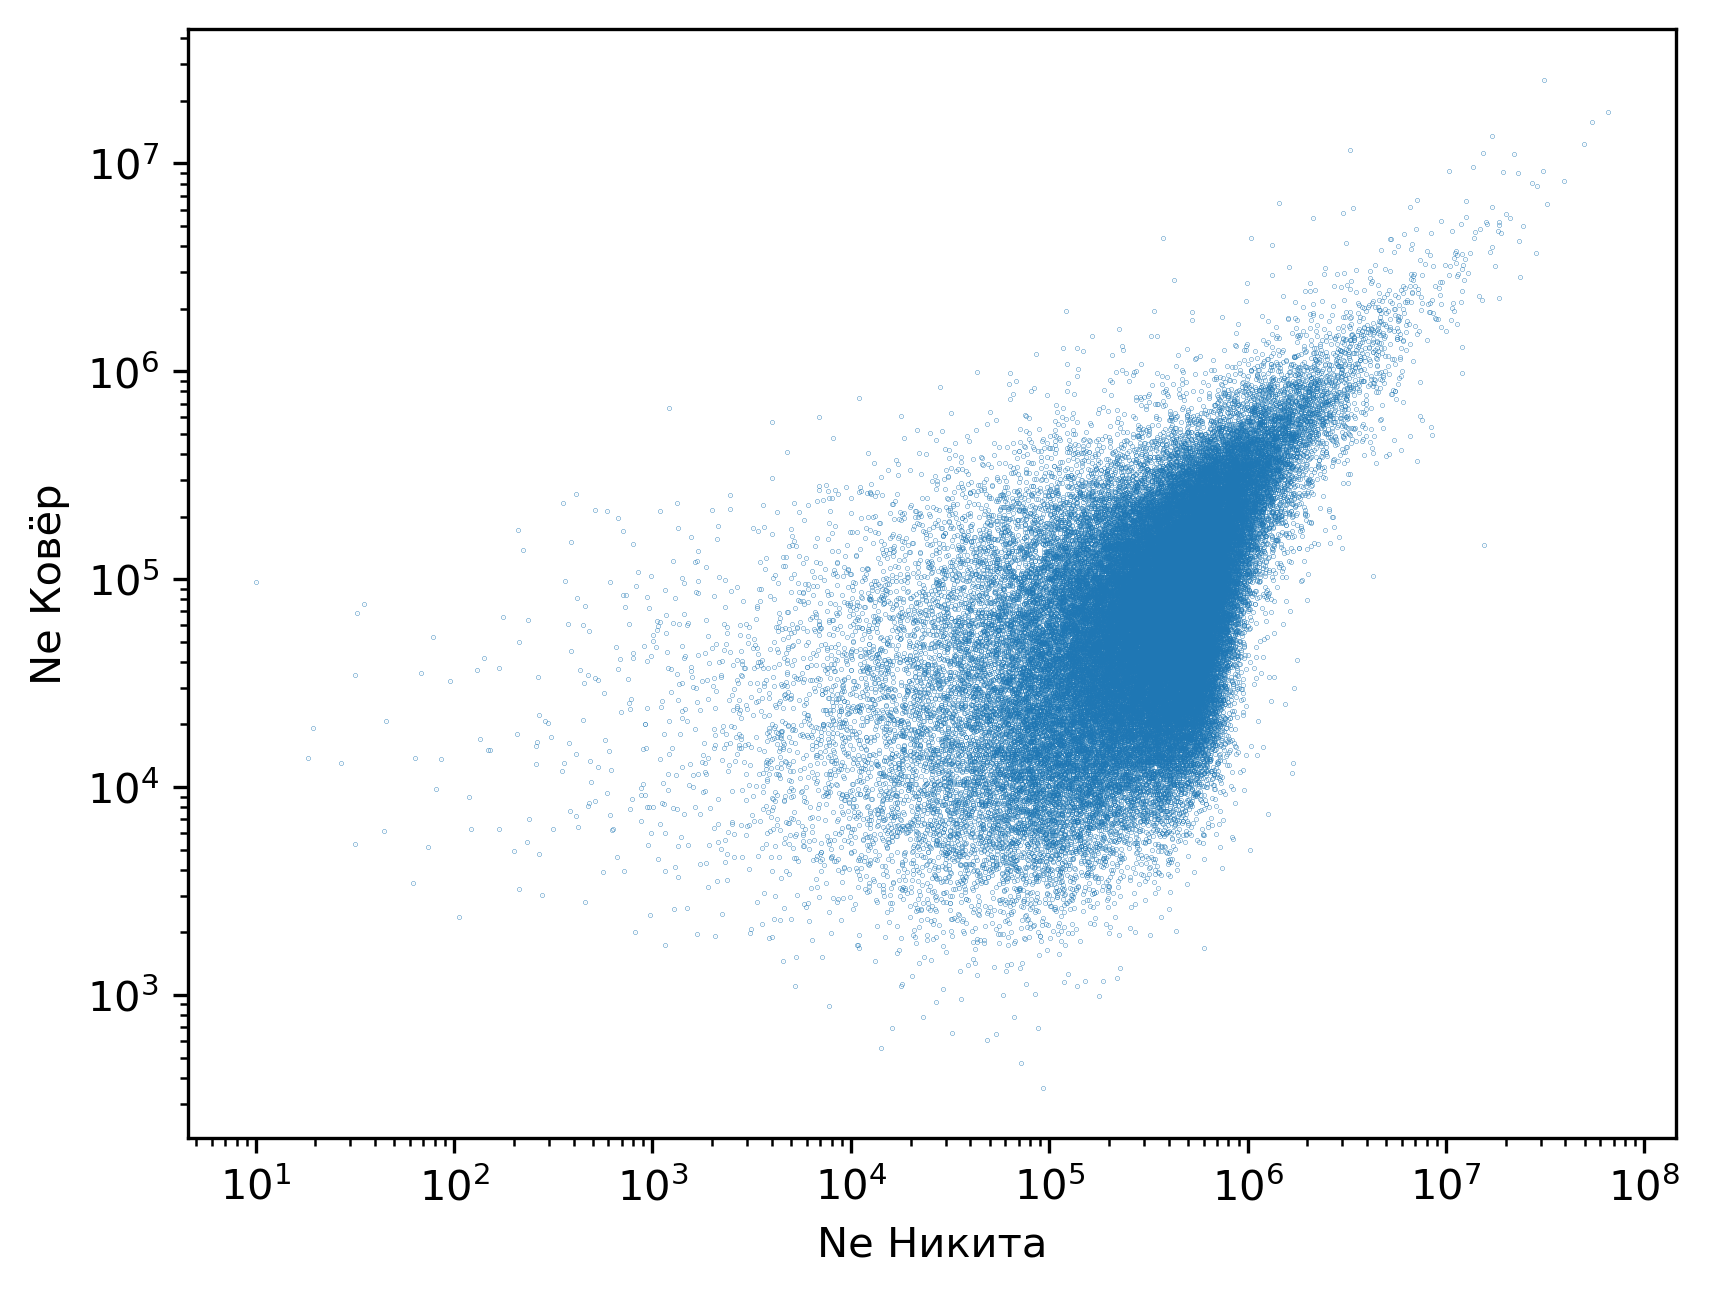

In [7]:
plt.scatter(Ne_rec, Ne_cov, s=0.01)

plt.xlabel('Ne Никита')
plt.ylabel('Ne Ковёр')

plt.yscale('log')
plt.xscale('log')

plt.savefig('Ne_plot.png')

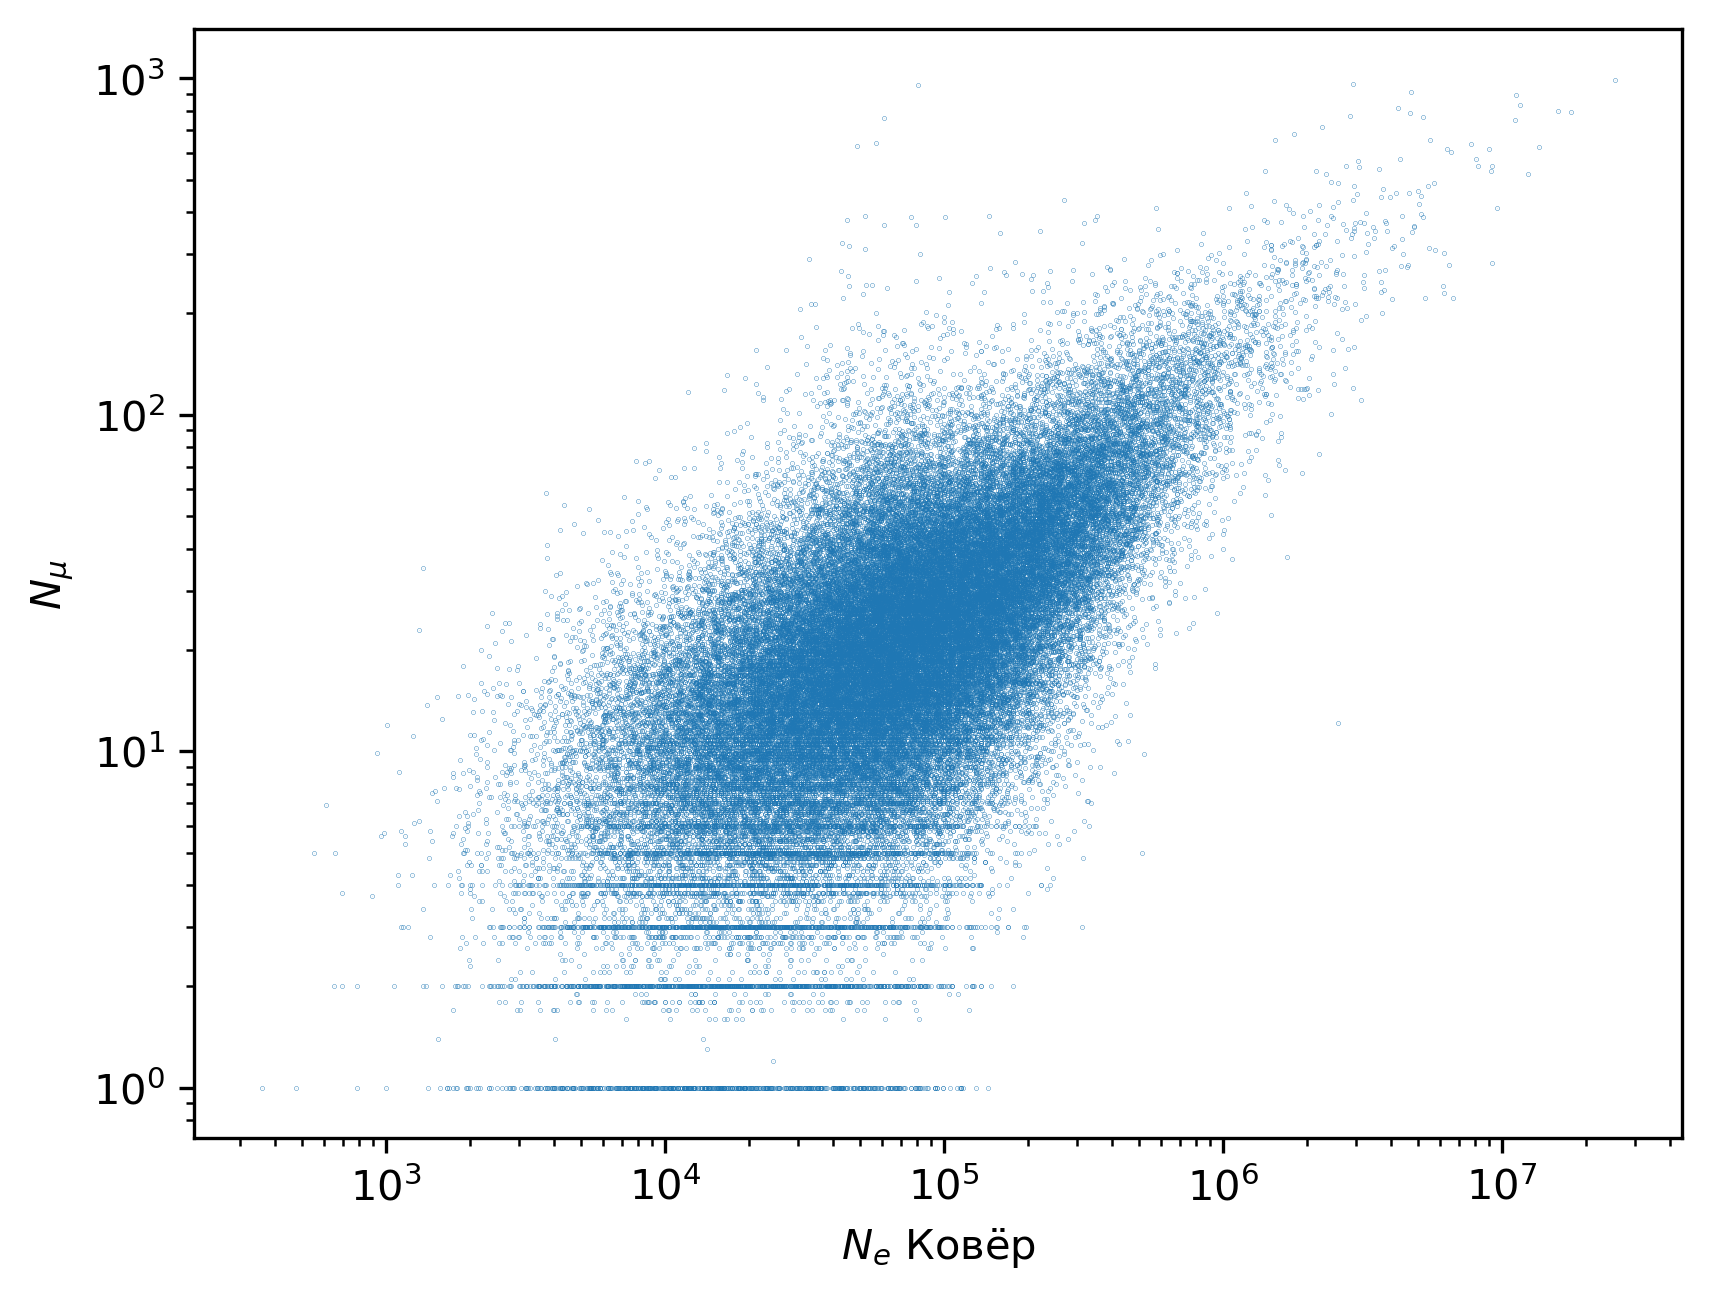

In [8]:
plt.scatter(Ne_cov, Nmu_cov, s=0.01)

plt.xlabel('$N_e$ Ковёр')
plt.ylabel('$N_\mu$')

plt.yscale('log')
plt.xscale('log')

plt.savefig('NeNmu_cov.png')

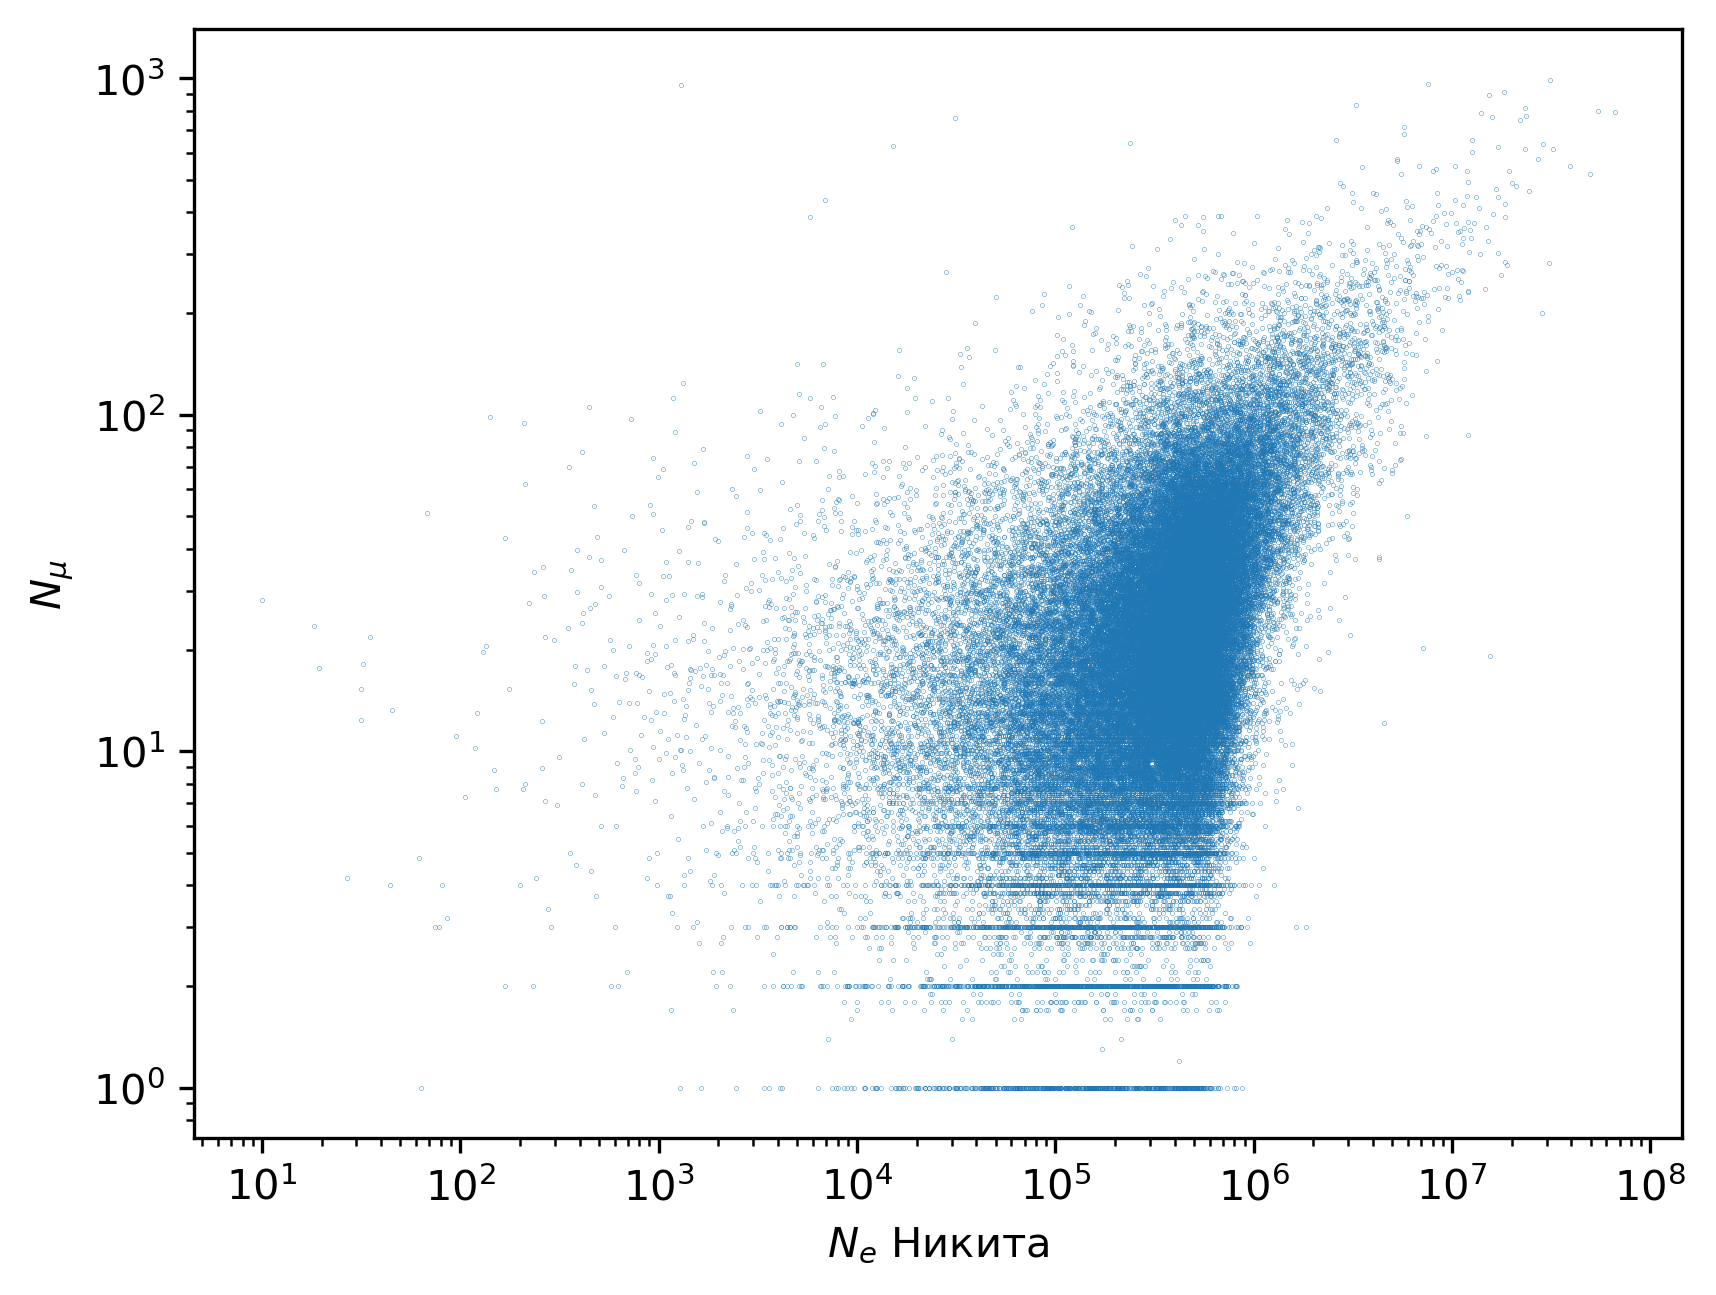

In [9]:
plt.scatter(Ne_rec, Nmu_cov, s=0.01)

plt.xlabel('$N_e$ Никита')
plt.ylabel('$N_\mu$')

plt.yscale('log')
plt.xscale('log')

plt.savefig('NeNmu_nik.png')

In [ ]:
# Ne_rec_vik = []
# Ne_cov_vik = []

# for i in range(carpet_Nes.size):
    
#     r, rho = get_rho(i)

#     try:
#         popt, pcov = curve_fit(NKG_Vik, r, rho, bounds=([0.4, 10], [1.8, 10**8]))
#         Ne_rec_vik.append(popt[1])
#         Ne_cov_vik.append(carpet_Nes[i])
#     except RuntimeError:
#         ...
#     except TypeError:
#         ...
#     except ValueError:
#         ...

In [ ]:
# plt.scatter(Ne_rec_vik, Ne_cov_vik, s=1)

# plt.xlabel('Ne Никита')
# plt.ylabel('Ne Ковёр')

# plt.yscale('log')
# plt.xscale('log')